In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm
from random import shuffle
import torch
from torch import nn
import math
from glob import glob
import sys
import shutil  

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


%matplotlib inline

In [ ]:
!pip install --upgrade --no-cache-dir gdown
import gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0


In [ ]:
#https://drive.google.com/drive/u/1/folders/1aw9AmGTb6Iw2gcIqwCJyDDInungGxg_j
#https://drive.google.com/drive/u/1/folders/1Iye3lkPex9kAnuWinr9NLmj51vAl5t5A

In [ ]:
# Download training data
url = "https://drive.google.com/drive/folders/16ZaNLVBZgn7RYFLiF1jt-WcCF1aRb8aP"
gdown.download_folder(url, quiet=True, use_cookies=False, remaining_ok=True)

['/content/Martian Inverted Channels/Aeolis Dorsa/images/ESP_020673_1750_RED.browse.jpg',
 '/content/Martian Inverted Channels/Aeolis Dorsa/images/ESP_031064_1760_RED.browse.jpg',
 '/content/Martian Inverted Channels/Aeolis Dorsa/images/ESP_035600_1765_RED.browse.jpg',
 '/content/Martian Inverted Channels/Aeolis Dorsa/images/ESP_039385_1760_RED.browse.jpg',
 '/content/Martian Inverted Channels/Aeolis Dorsa/images/ESP_048233_1770_RED.browse.jpg',
 '/content/Martian Inverted Channels/Aeolis Dorsa/images/ESP_053639_1760_RED.browse.jpg',
 '/content/Martian Inverted Channels/Aeolis Dorsa/images/ESP_055195_1735_RED.browse.jpg',
 '/content/Martian Inverted Channels/Aeolis Dorsa/images/ESP_071971_1760_RED.browse.jpg',
 '/content/Martian Inverted Channels/Aeolis Dorsa/images/ESP_072327_1750_RED.browse.jpg',
 '/content/Martian Inverted Channels/Aeolis Dorsa/images/PSP_009623_1755_RED.browse.jpg',
 '/content/Martian Inverted Channels/Aeolis Dorsa/images/PSP_010533_1755_RED.browse.jpg',
 '/content

In [ ]:
# Download test data
url = "https://drive.google.com/drive/folders/1dGwTm47UJSp0_qLl0n0VCUPMCu56xEZD"
gdown.download_folder(url, quiet=True, use_cookies=False, remaining_ok=True)

['/content/Test data/Aeolis Dorsa/images/ESP_072116_1740_RED.browse.jpg',
 '/content/Test data/Aeolis Dorsa/masks/ESP_072116_1740_RED.browse.png',
 '/content/Test data/Miyamoto Crater/images/ESP_016631_1770_RED.browse.jpg',
 '/content/Test data/Miyamoto Crater/images/ESP_074759_1855_RED.browse.jpg',
 '/content/Test data/Miyamoto Crater/masks/ESP_016631_1770_RED.browse.png',
 '/content/Test data/Miyamoto Crater/masks/ESP_074759_1855_RED.browse.png']

# Patch Learning

In [ ]:
import os
import numpy as np
import torch
import torch.utils.data
import torchvision.transforms as transforms
import PIL
import random
from scipy import ndimage


class segDataset(torch.utils.data.Dataset):
    def __init__(self, root, training, transform=None):
        super(segDataset, self).__init__()
        self.root = root
        self.training = training
        self.transform = transform
        self.IMG_NAMES = sorted(glob(self.root + '/*/images/*.jpg'))
        self.BGR_classes = {'Background' : [ 0, 0, 0],
                            'Inverted Channel' : [ 0, 0, 255]} # in BGR

        self.bin_classes = ['Background', 'Inverted Channel']


    def __getitem__(self, idx):
        
        img_path = self.IMG_NAMES[idx]
        mask_path = img_path.replace('images', 'masks').replace('.jpg', '.png')

        image = cv2.imread(img_path)
        mask = cv2.imread(mask_path)
        plt.imshow(mask)
        cls_mask = np.zeros(mask.shape)

        cls_mask[mask == self.BGR_classes['Background']] = self.bin_classes.index('Background')
        cls_mask[mask == self.BGR_classes['Inverted Channel']] = self.bin_classes.index('Inverted Channel')
        torch.set_printoptions(profile="full")
        #print("class mask",cls_mask)
        cls_mask = cls_mask[:,:,2] #removing nearby elements [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] -> [0,2,4,6,8]
        #print("---------------------------------------------------")
        #print(cls_mask)
        if self.training==True:
            if self.transform:
              image = transforms.functional.to_pil_image(image)
              image = self.transform(image)
              image = np.array(image)

            # 90 degree rotation
            if np.random.rand()<0.5:
              angle = np.random.randint(4) * 90
              image = ndimage.rotate(image,angle,reshape=True)
              cls_mask = ndimage.rotate(cls_mask,angle,reshape=True)

        # image = cv2.resize(image, (512,512))/255.0
        # cls_mask = cv2.resize(cls_mask, (512,512))
        image = cv2.resize(image, (512,512))/255.0
        cls_mask = cv2.resize(cls_mask, (512,512))
        # image = image/255.0
        
        image = np.moveaxis(image, -1, 0)

        return torch.tensor(image).float(), torch.tensor(cls_mask, dtype=torch.int64)


    def __len__(self):
        return len(self.IMG_NAMES)

In [ ]:
#color_shift = transforms.ColorJitter(.1,.1,.1,.1)
#blurriness = transforms.GaussianBlur(3, sigma=(0.1, 2.0))
#
#t = transforms.Compose([color_shift, blurriness])
#dataset = segDataset('./Martian Inverted Channels', training = True, transform= t)
dataset = segDataset('./Martian Inverted Channels', training = True)
print(dataset.IMG_NAMES)

len(dataset)

['./Martian Inverted Channels/Aeolis Dorsa/images/ESP_020673_1750_RED.browse.jpg', './Martian Inverted Channels/Aeolis Dorsa/images/ESP_031064_1760_RED.browse.jpg', './Martian Inverted Channels/Aeolis Dorsa/images/ESP_035600_1765_RED.browse.jpg', './Martian Inverted Channels/Aeolis Dorsa/images/ESP_039385_1760_RED.browse.jpg', './Martian Inverted Channels/Aeolis Dorsa/images/ESP_048233_1770_RED.browse.jpg', './Martian Inverted Channels/Aeolis Dorsa/images/ESP_053639_1760_RED.browse.jpg', './Martian Inverted Channels/Aeolis Dorsa/images/ESP_055195_1735_RED.browse.jpg', './Martian Inverted Channels/Aeolis Dorsa/images/ESP_071971_1760_RED.browse.jpg', './Martian Inverted Channels/Aeolis Dorsa/images/ESP_072327_1750_RED.browse.jpg', './Martian Inverted Channels/Aeolis Dorsa/images/PSP_009623_1755_RED.browse.jpg', './Martian Inverted Channels/Aeolis Dorsa/images/PSP_010533_1755_RED.browse.jpg', './Martian Inverted Channels/HVflip/images/ESP_012714_1815_RED.browse.jpg', './Martian Inverted C

80

In [ ]:
trainingDataset = segDataset('./Test data', training = False)
print(trainingDataset.IMG_NAMES)

len(trainingDataset)

['./Test data/Aeolis Dorsa/images/ESP_072116_1740_RED.browse.jpg', './Test data/Miyamoto Crater/images/ESP_016631_1770_RED.browse.jpg', './Test data/Miyamoto Crater/images/ESP_074759_1855_RED.browse.jpg']


3

In [ ]:
#test_num = int(0.1 * len(dataset))
#print(f'test data : {test_num}')
# Manual seed used to recreate the random split and get the same datasets
#train_dataset, test_dataset = torch.utils.data.random_split(dataset, [len(dataset)-test_num, test_num], generator=torch.Generator().manual_seed(181))
train_dataset = dataset
test_dataset = trainingDataset

In [ ]:
BACH_SIZE = 4
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BACH_SIZE, shuffle=True, num_workers=2)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=1, shuffle=False, num_workers=2)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [ ]:
import torch.nn.functional as F
from torch.nn import ModuleList
import torch



class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, out_channels=32):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        bilinear = False

        self.inc = DoubleConv(n_channels, out_channels)
        self.down1 = Down(out_channels, out_channels * 2)
        self.down2 = Down(out_channels * 2, out_channels * 4)
        self.down3 = Down(out_channels * 4, out_channels * 8)
        factor = 2 if bilinear else 1
        self.down4 = Down(out_channels * 8, out_channels * 16 // factor)
        self.up1 = Up(out_channels * 16, out_channels * 8 // factor, bilinear)
        self.up2 = Up(out_channels * 8, out_channels * 4 // factor, bilinear)
        self.up3 = Up(out_channels * 4, out_channels * 2 // factor, bilinear)
        self.up4 = Up(out_channels * 2, out_channels, bilinear)
        self.outc = OutConv(out_channels, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return x1, x, logits


class MiniUNet(nn.Module):
    def __init__(self, n_channels, n_classes, out_channels=32):
        super(MiniUNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        bilinear = False

        self.inc = DoubleConv(n_channels, out_channels)
        self.down1 = Down(out_channels, out_channels*2)
        self.down2 = Down(out_channels*2, out_channels*4)
        self.down3 = Down(out_channels*4, out_channels*8)
        self.up1 = Up(out_channels*8, out_channels*4, bilinear)
        self.up2 = Up(out_channels*4, out_channels*2, bilinear)
        self.up3 = Up(out_channels*2, out_channels, bilinear)
        self.outc = OutConv(out_channels, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x = self.up1(x4, x3)
        x = self.up2(x, x2)
        x = self.up3(x, x1)
        logits = self.outc(x)
        return x1, x, logits


class Iternet(nn.Module):
    def __init__(self, n_channels, n_classes, out_channels=32, iterations=3):
        super(Iternet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.iterations = iterations

        # define the network UNet layer
        self.model_unet = UNet(n_channels=n_channels,
                               n_classes=n_classes, out_channels=out_channels)

        # define the network MiniUNet layers
        self.model_miniunet = ModuleList(MiniUNet(
            n_channels=out_channels*2, n_classes=n_classes, out_channels=out_channels) for i in range(iterations))

    def forward(self, x):
        x1, x2, logits = self.model_unet(x)
        for i in range(self.iterations):
            x = torch.cat([x1, x2], dim=1)
            _, x2, logits = self.model_miniunet[i](x)

        return logits


In [ ]:
# # Not using -> Double Conv Class
import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [ ]:
# # Not using -> Double Conv Class
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)
        

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        #print("out ", logits.size())
        return logits

In [ ]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True, n_classes=2):
        super(DiceLoss, self).__init__()
        self.classes = n_classes

    def to_one_hot(self, tensor):
        n,h,w = tensor.size()
        one_hot = torch.zeros(n,self.classes,h,w).to(tensor.device).scatter_(1,tensor.view(n,1,h,w),1)
        return one_hot

    def forward(self, inputs, target):
       
        N = inputs.size()[0]
       

        # predicted probabilities for each pixel along channel
        inputs = F.softmax(inputs,dim=1)
        
        
        # Numerator Product
        target_oneHot = self.to_one_hot(target)
         #weight_invertedChannels = 1.0
         #weight_background = 0.04

        inter = inputs * target_oneHot
        #print("inter size", inter.size())
        #(2.*intersection + smooth)/(inputs.sum() + target.sum() + smooth)
        intersection = 0
        smooth = 1

        for imageInd in range(N): 
          intersection += inter[imageInd][1].view(-1).sum() 
           #intersection += inter[imageInd][0].view(-1).sum() * weight_background

        inter = 2*intersection + smooth
        #Denominator 
        union= inputs + target_oneHot
        ## Sum over all pixels N x C x H x W => N x C

        total2 = 0
        for imageInd in range(N):
          total2 += union[imageInd][1].view(-1).sum() 
           #total2 += union[imageInd][0].view(-1).sum() * weight_background

        union = total2 + smooth
        #union = union.view(N,self.classes,-1).sum(2)

        loss = inter/union
        ## Return average loss over classes and batch
        return 1-loss.mean()

In [ ]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True, n_classes=2):
        super(DiceLoss, self).__init__()
        self.classes = n_classes

    def to_one_hot(self, tensor):
        n,h,w = tensor.size()
        one_hot = torch.zeros(n,self.classes,h,w).to(tensor.device).scatter_(1,tensor.view(n,1,h,w),1)
        return one_hot

    def forward(self, inputs, target):
       
        N = inputs.size()[0]
       

        # predicted probabilities for each pixel along channel
        inputs = F.softmax(inputs,dim=1)
        
        
        # Numerator Product
        target_oneHot = self.to_one_hot(target)
         #weight_invertedChannels = 1.0
         #weight_background = 0.04

        inter = inputs * target_oneHot
        #print("inter size", inter.size())
        #(2.*intersection + smooth)/(inputs.sum() + target.sum() + smooth)
        intersection = 0
        smooth = 1

        for imageInd in range(N): 
          intersection += inter[imageInd][1].view(-1).sum() 
           #intersection += inter[imageInd][0].view(-1).sum() * weight_background

        inter = intersection + smooth
        #Denominator 
        union= inputs
        ## Sum over all pixels N x C x H x W => N x C

        total2 = 0
        for imageInd in range(N):
          total2 += union[imageInd][1].view(-1).sum() 
           #total2 += union[imageInd][0].view(-1).sum() * weight_background

        union = total2 + smooth
        #union = union.view(N,self.classes,-1).sum(2)

        loss = inter/union
        ## Return average loss over classes and batch
        return 1-loss.mean()

In [ ]:
# Updated
class WeightedDiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True, n_classes=2):
        super(WeightedDiceLoss, self).__init__()
        self.classes = n_classes

    def to_one_hot(self, tensor):
        n,h,w = tensor.size()
        one_hot = torch.zeros(n,self.classes,h,w).to(tensor.device).scatter_(1,tensor.view(n,1,h,w),1)
        return one_hot

    def forward(self, inputs, target):
       
        N = inputs.size()[0]
       

        # predicted probabilities for each pixel along channel
        inputs = F.softmax(inputs,dim=1)
        
        
        # Numerator Product
        target_oneHot = self.to_one_hot(target)
        

        inter = 2*inputs * target_oneHot
        #print("inter size", inter.size())
        #(2.*intersection + smooth)/(inputs.sum() + target.sum() + smooth)
        intersection_channels = 0
        intersection_background = 0
        # smooth = 1

        for imageInd in range(N): 
          intersection_channels += inter[imageInd][1].view(-1).sum() 
          intersection_background += inter[imageInd][0].view(-1).sum() 

        # inter = intersection 
        #print("inter ", inter)
        #Denominator 
        union= inputs + target_oneHot 
        ## Sum over all pixels N x C x H x W => N x C
        union_channels=0
        union_background = 0
        total2 = 0
        for imageInd in range(N):
          union_channels += union[imageInd][1].view(-1).sum() 
          union_background += union[imageInd][0].view(-1).sum() 

        # union = total2
        #print("union ", union)
        #union = union.view(N,self.classes,-1).sum(2)
        dice_channels =intersection_channels/union_channels
        dice_channels = dice_channels.mean()*0.8

        dice_background =intersection_background/union_background
        dice_background = dice_background.mean()*0.2

        weighted_dice = (dice_channels+ dice_background)

        loss = 1 - weighted_dice
        #print("loss ", loss)
        #print("loss mean ", loss.mean())
        ## Return average loss over classes and batch
        # return 1-loss.mean()
        return loss

In [ ]:
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True, n_classes=2):
        super(DiceBCELoss, self).__init__()
        self.classes = n_classes

    def to_one_hot(self, tensor):
        n,h,w = tensor.size()
        one_hot = torch.zeros(n,self.classes,h,w).to(tensor.device).scatter_(1,tensor.view(n,1,h,w),1)
        return one_hot

    def forward(self, inputs, target):
       
        N = inputs.size()[0]
       

        # predicted probabilities for each pixel along channel
        inputs = F.softmax(inputs,dim=1)
        
        
        # Numerator Product
        target_oneHot = self.to_one_hot(target)
        smooth = 1

        weight_invertedChannels = 3
        weight_background = 1

        inter = inputs * target_oneHot
        #print("inter size", inter.size())
        #(2.*intersection + smooth)/(inputs.sum() + target.sum() + smooth)
        intersection_channels = 0
        intersection_background = 0
        # smooth = 1

        for imageInd in range(N): 
          intersection_channels += inter[imageInd][1].view(-1).sum() 
          intersection_background += inter[imageInd][0].view(-1).sum() 

        # inter = intersection 
        #print("inter ", inter)
        #Denominator 
        union= inputs + target_oneHot
        ## Sum over all pixels N x C x H x W => N x C
        union_channels=0
        union_background = 0
        total2 = 0
        for imageInd in range(N):
          union_channels += union[imageInd][1].view(-1).sum() 
          union_background += union[imageInd][0].view(-1).sum() 

        # union = total2
        #print("union ", union)
        #union = union.view(N,self.classes,-1).sum(2)
        dice_channels =intersection_channels/union_channels
        dice_channels = dice_channels.mean()*0.9

        dice_background =intersection_background/union_background
        dice_background = dice_background.mean()*0.1

        weighted_dice = (dice_channels+ dice_background)
        
        inputs = inputs.view(-1)
        targets = target_oneHot.view(-1)
        # intersection = (inputs * targets).sum()  
        # dice = ((2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth))                     
        dice_loss = 1 -  weighted_dice
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean').mean()  
        Dice_BCE = (0.4*BCE + 0.6*dice_loss)

        ## Return average loss over classes and batch
        return Dice_BCE

In [ ]:
criterion = WeightedDiceLoss(n_classes=2).to(device)

In [ ]:
def acc(label, predicted):
  seg_acc = (y.cpu() == torch.argmax(pred_mask, axis=1).cpu()).sum() / torch.numel(y.cpu())
  return seg_acc

In [ ]:
min_loss = torch.tensor(float('inf'))

model = Iternet(n_channels=3, n_classes=2).to(device)
# model = UNet(n_channels=3, n_classes=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)

In [ ]:
from pprint import pprint
os.makedirs('./saved_models', exist_ok=True)

N_EPOCHS = 30
N_DATA = len(train_dataset)
N_TEST = len(test_dataset)

plot_losses = []
scheduler_counter = 0
prediction = []

for epoch in range(N_EPOCHS):
  # training
  model.train()
  loss_list = []
  acc_list = []
  for batch_i, (x, y) in enumerate(train_dataloader):

      pred_mask = model(x.to(device))
      #torch.set_printoptions(profile="full")
      #pprint(pred_mask)
      #
      #np.savetxt('my_file.txt', pred_mask.detach().numpy())
      #savingMask = F.softmax(pred_mask, dim = 1)
      #savingMask = torch.flatten(pred_mask)
      #np.savetxt('my_file1.txt', savingMask.detach().numpy())
      #torch.save(savingMask, 'file2.txt')

      loss = criterion(pred_mask, y.to(device))

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      loss_list.append(loss.cpu().detach().numpy())
      acc_list.append(acc(y,pred_mask).numpy())

      sys.stdout.write(
          "\r[Epoch %d/%d] [Batch %d/%d] [Loss: %f (%f)]"
          % (
              epoch,
              N_EPOCHS,
              batch_i,
              len(train_dataloader),
              loss.cpu().detach().numpy(),
              np.mean(loss_list),
          )
      )
  scheduler_counter += 1
  # testing
  model.eval()
  val_loss_list = []
  val_acc_list = []
  for batch_i, (x, y) in enumerate(test_dataloader):
      with torch.no_grad():    
          pred_mask = model(x.to(device))
      val_loss = criterion(pred_mask, y.to(device))
      val_loss_list.append(val_loss.cpu().detach().numpy())
      val_acc_list.append(acc(y,pred_mask).numpy())
    
  print(' epoch {} - loss : {:.5f} - acc : {:.2f} - val loss : {:.5f} - val acc : {:.2f}'.format(epoch, 
                                                                                                 np.mean(loss_list), 
                                                                                                 np.mean(acc_list), 
                                                                                                 np.mean(val_loss_list),
                                                                                                 np.mean(val_acc_list)))
  plot_losses.append([epoch, np.mean(loss_list), np.mean(val_loss_list)])
  #print("prediction ", prediction.size(), prediction.data[0])
  compare_loss = np.mean(val_loss_list)
  is_best = compare_loss < min_loss
  if is_best == True:
    scheduler_counter = 0
    min_loss = min(compare_loss, min_loss)
  torch.save(model.state_dict(), './saved_models/unet_epoch_{}_{:.5f}.pt'.format(epoch,np.mean(val_loss_list)))
  
  if scheduler_counter > 5:
    lr_scheduler.step()
    print(f"lowering learning rate to {optimizer.param_groups[0]['lr']}")
    scheduler_counter = 0


[Epoch 0/30] [Batch 19/20] [Loss: 0.752492 (0.797955)] epoch 0 - loss : 0.79795 - acc : 0.84 - val loss : 0.95223 - val acc : 0.03
[Epoch 1/30] [Batch 19/20] [Loss: 0.752404 (0.775904)] epoch 1 - loss : 0.77590 - acc : 0.95 - val loss : 0.78116 - val acc : 0.97
[Epoch 2/30] [Batch 19/20] [Loss: 0.757764 (0.772381)] epoch 2 - loss : 0.77238 - acc : 0.97 - val loss : 0.78913 - val acc : 0.97
[Epoch 3/30] [Batch 19/20] [Loss: 0.768779 (0.764027)] epoch 3 - loss : 0.76403 - acc : 0.97 - val loss : 0.76900 - val acc : 0.97
[Epoch 4/30] [Batch 19/20] [Loss: 0.789488 (0.758964)] epoch 4 - loss : 0.75896 - acc : 0.91 - val loss : 0.72376 - val acc : 0.95
[Epoch 5/30] [Batch 19/20] [Loss: 0.769047 (0.747643)] epoch 5 - loss : 0.74764 - acc : 0.92 - val loss : 0.75649 - val acc : 0.97
[Epoch 6/30] [Batch 19/20] [Loss: 0.775491 (0.746589)] epoch 6 - loss : 0.74659 - acc : 0.91 - val loss : 0.93420 - val acc : 0.07
[Epoch 7/30] [Batch 19/20] [Loss: 0.782236 (0.763072)] epoch 7 - loss : 0.76307 - a

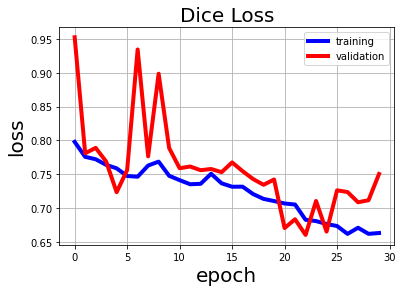

In [ ]:
# plot loss
plot_losses = np.array(plot_losses)
plt.plot(plot_losses[:,0], plot_losses[:,1], color='b', linewidth=4)
plt.plot(plot_losses[:,0], plot_losses[:,2], color='r', linewidth=4)
plt.title('Dice Loss', fontsize=20)
plt.xlabel('epoch',fontsize=20)
plt.ylabel('loss',fontsize=20)
plt.grid()
plt.legend(['training', 'validation']) # using a named size
plt.show()

In [ ]:
model.load_state_dict(torch.load('/content/saved_models/unet_epoch_29_0.75063.pt'))

<All keys matched successfully>

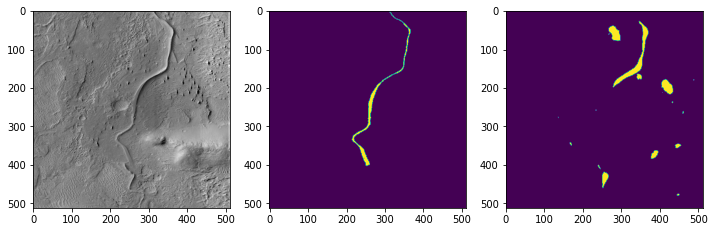

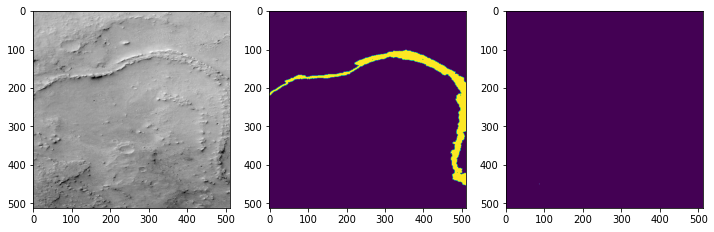

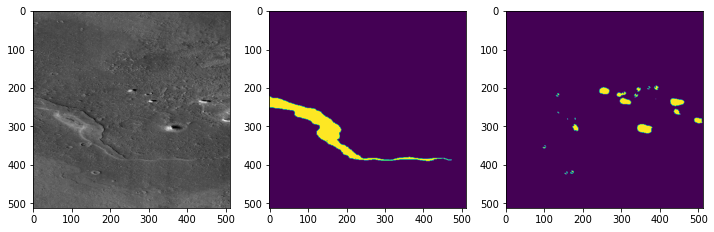

In [ ]:
model.eval()

for batch_i, (x, y) in enumerate(test_dataloader):
    for j in range(len(x)):
        result = model(x.to(device)[j:j+1])
        mask = torch.argmax(result, axis=1).cpu().detach().numpy()[0]
        im = np.moveaxis(x.to(device)[j].cpu().detach().numpy(), 0, -1).copy()*255
        im = im.astype(int)
        gt_mask = y[j]

        plt.figure(figsize=(12,12))

        plt.subplot(1,3,1)
        im = np.moveaxis(x.to(device)[j].cpu().detach().numpy(), 0, -1).copy()*255
        im = im.astype(int)
        plt.imshow(im)

        plt.subplot(1,3,2)
        plt.imshow(gt_mask)

        plt.subplot(1,3,3)
        plt.imshow(mask)

        

        plt.show()